In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-03-05 19:14:43--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-03-05 19:14:44--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-03-05 19:14:45--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
[os.path.join(input_dir, fname)
  for fname in os.listdir(input_dir)
  if fname.endswith(".jpg")])
target_paths = sorted(
[os.path.join(target_dir, fname)
  for fname in os.listdir(target_dir)
  if fname.endswith(".png") and not fname.startswith(".")])

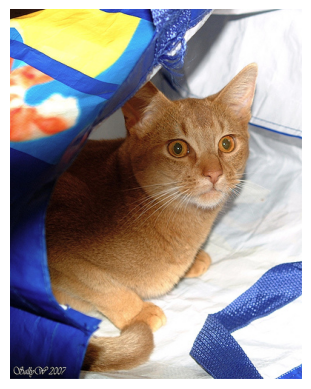

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[2]))

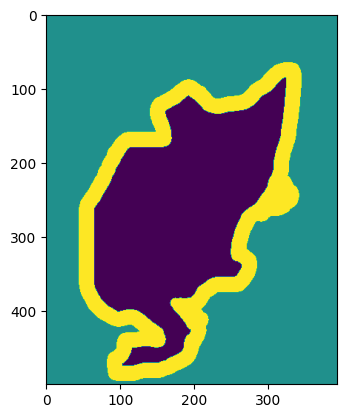

In [4]:
def display_target(target_array):
  target_array = (target_array.astype("uint8") - 1) * 127
  plt.imshow(target_array[:, :, 0])

img = img_to_array(load_img(target_paths[2], color_mode="grayscale"))
display_target(img)

In [5]:
import numpy as np
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)
def path_to_input_image(path):
   return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
   img = img_to_array( load_img(path, target_size=img_size, color_mode="grayscale"))
   img = img.astype("uint8") - 1
   return img
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
   input_imgs[i] = path_to_input_image(input_img_paths[i])
   targets[i] = path_to_target(target_paths[i])
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [6]:
@keras.saving.register_keras_serializable()
class SegmentationModel(keras.Model):
  def __init__(self, num_classes):
    super().__init__()
    self.rescal = layers.Rescaling(1./255)
    self.conv1 = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")
    self.conv2 = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")
    self.conv3 = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")
    self.conv4 = layers.Conv2D(128, 3, strides=1, padding="same", activation="relu")
    self.conv5 = layers.Conv2D(256, 3, strides=1, padding="same", activation="relu")
    self.conv6 = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")

    self.conv_transpose1 = layers.Conv2DTranspose(256, 3, strides=1, padding="same", activation="relu")
    self.conv_transpose2 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu")
    self.conv_transpose3 = layers.Conv2DTranspose(128, 3, strides=1, padding="same", activation="relu")
    self.conv_transpose4 = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")
    self.conv_transpose5 = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")
    self.conv_transpose6 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")

    self.outp = layers.Conv2D(num_classes, 3, padding="same", activation="relu")

  def call(self, x):
    out = self.rescal(x)
    out = self.conv1(out)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.conv_transpose1(out)
    out = self.conv_transpose2(out)
    out = self.conv_transpose3(out)
    out = self.conv_transpose4(out)
    out = self.conv_transpose5(out)
    out = self.conv_transpose6(out)
    out = self.outp(out)
    return out



In [7]:
model = SegmentationModel(3)

In [8]:
train_input_imgs.shape
train_targets.shape

(6390, 200, 200, 1)

In [9]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
  keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
  save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
epochs=1,
callbacks=callbacks,
batch_size=64,
validation_data=(val_input_imgs, val_targets))

100/100 [==============================] - 124s 919ms/step - loss: 1.1700 - val_loss: 0.9608


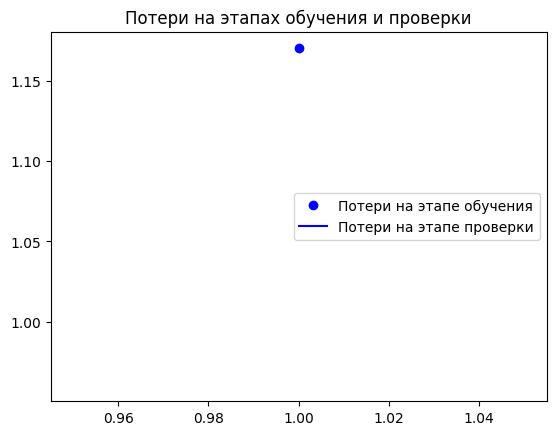

In [10]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Потери на этапе обучения")
plt.plot(epochs, val_loss, "b", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.legend()

1/1 [==============================] - 0s 418ms/step


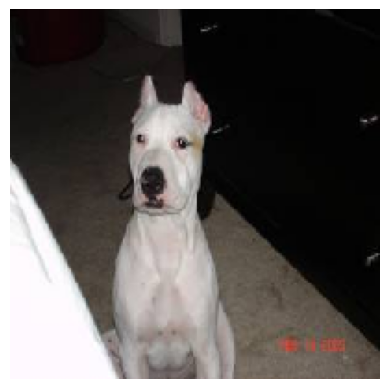

In [12]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]


(200, 200)
[[127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [  0 127   0 ... 127   0 127]
 ...
 [127 127 127 ... 127 127 127]
 [  0 127   0 ... 127   0 127]
 [127 127 127 ... 127 127 127]]


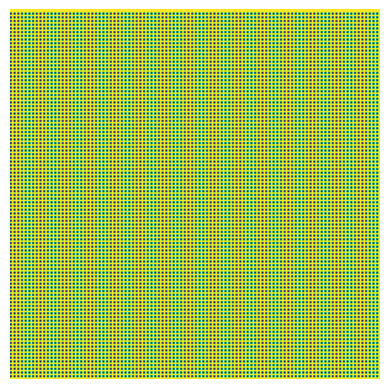

In [24]:
def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  print(mask.shape)
  mask *= 127
  print(mask)
  plt.axis("off")
  plt.imshow(mask)
display_mask(mask)

In [15]:
test_image.shape

(200, 200, 3)

In [26]:
mask

array([[[0.        , 0.00281585, 0.        ],
        [0.        , 0.0297015 , 0.        ],
        [0.        , 0.00305162, 0.        ],
        ...,
        [0.        , 0.03424108, 0.        ],
        [0.        , 0.00195946, 0.        ],
        [0.00110279, 0.01891046, 0.        ]],

       [[0.00849672, 0.03085571, 0.00088286],
        [0.        , 0.02957674, 0.00269295],
        [0.01728478, 0.05332843, 0.00390884],
        ...,
        [0.        , 0.03547502, 0.00215974],
        [0.01830953, 0.05121276, 0.00494818],
        [0.        , 0.02744165, 0.00154919]],

       [[0.        , 0.        , 0.        ],
        [0.00684572, 0.0439468 , 0.00174868],
        [0.        , 0.        , 0.        ],
        ...,
        [0.01365343, 0.05518334, 0.0053957 ],
        [0.        , 0.        , 0.        ],
        [0.0052557 , 0.02842132, 0.00078465]],

       ...,

       [[0.02185918, 0.05091302, 0.00931651],
        [0.0113996 , 0.04793125, 0.00527103],
        [0.05742916, 0

In [20]:
model.predict(np.expand_dims(test_image, 0)).shape

1/1 [==============================] - 0s 40ms/step


(1, 200, 200, 3)

In [22]:
np.expand_dims(test_image, 0).shape

(1, 200, 200, 3)